Name: Rana Nameer Hussain Khan

Class: BESE 10-B

CMS ID: 286271

CS-405: Deep Learning

LAB 7

OPEN ENDED LAB

In [ ]:
#!pip install torch torchvision
#!pip install opencv-contrib-python
#!pip install scikit-learn

In [ ]:
# import the necessary packages
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten
import torchvision

import matplotlib
from sklearn.metrics import classification_report
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.datasets import KMNIST
from torch.optim import Adam
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import torch
import time

In [ ]:
class LeNet(Module):
  def __init__(self, numChannels, classes):
    # call the parent constructor
    super(LeNet, self).__init__()

    self.conv1 = Conv2d(in_channels=numChannels, out_channels=20, kernel_size=(5, 5))
    self.relu1 = ReLU()
    self.maxpool1 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

    self.conv2 = Conv2d(in_channels=20, out_channels=50, kernel_size=(5, 5))
    self.relu2 = ReLU()
    self.maxpool2 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

    self.fc1 = Linear(in_features=800, out_features=500)
    self.relu3 = ReLU()

    self.fc2 = Linear(in_features=500, out_features=classes)
    self.logSoftmax = LogSoftmax(dim=1)

  def forward(self, x):
    # pass the input through our first set of CONV => RELU => POOL layers
    x = self.conv1(x)
    x = self.relu1(x)
    x = self.maxpool1(x)
    # pass the output from the previous layer through the second set of CONV => RELU => POOL layers
    x = self.conv2(x)
    x = self.relu2(x)
    x = self.maxpool2(x)
    # flatten the output from the previous layer and pass it through our only set of FC => RELU layers
    x = flatten(x, 1)
    x = self.fc1(x)
    x = self.relu3(x)
    # pass the output to our softmax classifier to get our output predictions
    x = self.fc2(x)
    output = self.logSoftmax(x)
    # return the output predictions
    return output

In [ ]:
# define training hyperparameters
INIT_LR = 1e-3
BATCH_SIZE = 64
EPOCHS = 5
TRAIN_SPLIT = 0.75
VAL_SPLIT = 1 - TRAIN_SPLIT
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# load the dataset
print("[INFO] loading dataset...")

import torchvision.transforms as transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize(227)])

trainData = KMNIST(root="data", train=True, download=True, transform=ToTensor())
testData = KMNIST(root="data", train=False, download=True, transform=ToTensor())



print("[INFO] generating the train/validation split...")
numTrainSamples = int(len(trainData) * TRAIN_SPLIT)
numValSamples = int(len(trainData) * VAL_SPLIT)
(trainData, valData) = random_split(trainData,
	[numTrainSamples, numValSamples],
	generator=torch.Generator().manual_seed(42))

[INFO] loading dataset...


  0%|          | 0/18165135 [00:00<?, ?it/s]

Extracting data/KMNIST/raw/train-images-idx3-ubyte.gz to data/KMNIST/raw



  0%|          | 0/29497 [00:00<?, ?it/s]

Extracting data/KMNIST/raw/train-labels-idx1-ubyte.gz to data/KMNIST/raw



  0%|          | 0/3041136 [00:00<?, ?it/s]

Extracting data/KMNIST/raw/t10k-images-idx3-ubyte.gz to data/KMNIST/raw



  0%|          | 0/5120 [00:00<?, ?it/s]

Extracting data/KMNIST/raw/t10k-labels-idx1-ubyte.gz to data/KMNIST/raw

[INFO] generating the train/validation split...


In [ ]:
# initialize the train, validation, and test data loaders
trainDataLoader = DataLoader(trainData, shuffle=True,	batch_size=BATCH_SIZE)
valDataLoader = DataLoader(valData, batch_size=BATCH_SIZE)
testDataLoader = DataLoader(testData, batch_size=BATCH_SIZE)

# calculate steps per epoch for training and validation set
trainSteps = len(trainDataLoader.dataset) // BATCH_SIZE
valSteps = len(valDataLoader.dataset) // BATCH_SIZE


In [ ]:
# initialize the model
print("[INFO] initializing the model...")
model = LeNet(numChannels=1, classes=len(trainData.dataset.classes)).to(device)


model.eval()

[INFO] initializing the model...


LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (logSoftmax): LogSoftmax(dim=1)
)

In [ ]:
opt = Adam(model.parameters(), lr=INIT_LR)
lossFn = nn.NLLLoss()
# initialize a dictionary to store training history
H = {
	"train_loss": [],
	"train_acc": [],
	"val_loss": [],
	"val_acc": []
}
print(type(trainDataLoader),len(trainDataLoader))

<class 'torch.utils.data.dataloader.DataLoader'> 704


In [ ]:
# Let's start the training
print("[INFO] training the network...")
startTime = time.time()

# loop over epochs
for e in range(0, EPOCHS):
  model.train()                                            # set the model in training mode

  totalTrainLoss = 0
  totalValLoss = 0
  trainCorrect = 0
  valCorrect = 0
  # loop over the training set
  for (x, y) in trainDataLoader:
    (x, y) = (x.to(device), y.to(device))
  #for i, data in trainDataLoader:
    #x, y = data[0].to(device), data[1].to(device)
    pred = model(x)                                         # perform forward pass
    loss = lossFn(pred, y)                                  # calculate the training loss

    opt.zero_grad()                                         # zero out the gradients, perform the backpropagation step
    loss.backward()                                         # and update the weights
    opt.step()

    totalTrainLoss += loss
    trainCorrect += (pred.argmax(1) == y).type(
      torch.float).sum().item()

[INFO] training the network...


In [ ]:
    with torch.no_grad():                             # switch off autograd for evaluation
      model.eval()                                    # set the model in evaluation mode
      for (x, y) in valDataLoader:
        (x, y) = (x.to(device), y.to(device))
        pred = model(x)                               # # make the predictions
        totalValLoss += lossFn(pred, y)
        valCorrect += (pred.argmax(1) == y).type(
          torch.float).sum().item()

    avgTrainLoss = totalTrainLoss / trainSteps
    avgValLoss = totalValLoss / valSteps

    trainCorrect = trainCorrect / len(trainDataLoader.dataset)
    valCorrect = valCorrect / len(valDataLoader.dataset)

    H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["train_acc"].append(trainCorrect)
    H["val_loss"].append(avgValLoss.cpu().detach().numpy())
    H["val_acc"].append(valCorrect)

    print("[INFO] EPOCH: {}/{}".format(e + 1, EPOCHS))
    print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(avgTrainLoss, trainCorrect))
    print("Val loss: {:.6f}, Val accuracy: {:.4f}\n".format(avgValLoss, valCorrect))

endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))

[INFO] EPOCH: 5/5
Train loss: 0.025147, Train accuracy: 0.0000
Val loss: 0.129965, Val accuracy: 0.9829

[INFO] total time taken to train the model: 229.56s


In [ ]:
# we can now evaluate the network on the test set
print("[INFO] Testing Trained Model")
with torch.no_grad():
	model.eval()
	preds = []
	for (x, y) in testDataLoader:
		x = x.to(device)
		pred = model(x)
		preds.extend(pred.argmax(axis=1).cpu().numpy())

print(classification_report(testData.targets.cpu().numpy(),
	np.array(preds), target_names=testData.classes))

[INFO] Testing Trained Model
              precision    recall  f1-score   support

           o       0.97      0.94      0.95      1000
          ki       0.97      0.92      0.94      1000
          su       0.96      0.88      0.92      1000
         tsu       0.96      0.95      0.96      1000
          na       0.92      0.94      0.93      1000
          ha       0.96      0.95      0.95      1000
          ma       0.89      0.98      0.93      1000
          ya       0.96      0.94      0.95      1000
          re       0.94      0.99      0.96      1000
          wo       0.95      0.96      0.95      1000

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



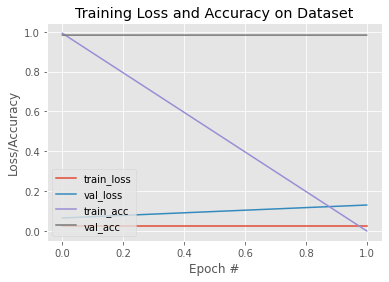

<Figure size 432x288 with 0 Axes>

In [ ]:
%matplotlib inline
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["val_loss"], label="val_loss")
plt.plot(H["train_acc"], label="train_acc")
plt.plot(H["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()
plt.savefig("plot")

# serialize the model to disk
torch.save(model, "model")

Implementing VGG16 from scratch in PyTorch to classify the CIFAR10 Dataset

Task :  Your task is to use the following given code structure and use any base architecture for classification instead of LeNet and train and test it using CFAR10 dataset. Basically your task is to make necessary changes to acheive the given objective.

In [1]:
import torch
import torch.nn as nn

class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Instantiate the model
model = VGG16()

# Print the model architecture
print(model)


VGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

In [2]:
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)


100%|██████████| 170498071/170498071 [00:05<00:00, 29867010.71it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [3]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if i % 100 == 99:    # Print every 100 mini-batches
            print(f'Epoch [{epoch+1}, {i+1:5d}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0


Epoch [1,   100] loss: 2.303
Epoch [1,   200] loss: 2.303
Epoch [1,   300] loss: 2.302
Epoch [1,   400] loss: 2.303
Epoch [1,   500] loss: 2.303
Epoch [1,   600] loss: 2.303
Epoch [1,   700] loss: 2.303
Epoch [2,   100] loss: 2.303
Epoch [2,   200] loss: 2.303
Epoch [2,   300] loss: 2.303
Epoch [2,   400] loss: 2.303
Epoch [2,   500] loss: 2.303
Epoch [2,   600] loss: 2.303
Epoch [2,   700] loss: 2.303
Epoch [3,   100] loss: 2.303
Epoch [3,   200] loss: 2.303
Epoch [3,   300] loss: 2.303
Epoch [3,   400] loss: 2.303
Epoch [3,   500] loss: 2.303
Epoch [3,   600] loss: 2.303
Epoch [3,   700] loss: 2.303
